In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# load rtx4060 data
all_data = []
for ncpu in [1, 2, 4, 8, 16, 32]:
    df = pd.read_csv(f'notes/data/rtx4060/{ncpu}cpu.csv')
    df['gpu_type'] = 'rtx4060'
    df['ncpu'] = ncpu
    all_data.append(df)


for ncpu in [1, 2, 4, 8, 16, 32]:
    df = pd.read_csv(f'notes/data/v100/{ncpu}cpu.csv')
    df['gpu_type'] = 'v100'
    df['ncpu'] = ncpu
    all_data.append(df)

for ncpu in [1, 2, 4, 8, 16, 32]:
    df = pd.read_csv(f'notes/data/rtx4090/{ncpu}cpu.csv')
    df['gpu_type'] = 'rtx4090'
    df['ncpu'] = ncpu
    all_data.append(df)

for ncpu in [1, 2, 4, 8, 16, 32]:
    df = pd.read_csv(f'notes/data/a100/{ncpu}cpu.csv')
    df['gpu_type'] = 'a100'
    df['ncpu'] = ncpu
    all_data.append(df)

for ncpu in [1, 2, 4, 8, 16, 32]:
    df = pd.read_csv(f'notes/data/h100/{ncpu}cpu.csv')
    df['gpu_type'] = 'h100'
    df['ncpu'] = ncpu
    all_data.append(df)

for ncpu in [1, 2, 4, 8, 16, 32]:
    df = pd.read_csv(f'notes/data/h200/{ncpu}cpu.csv')
    df['gpu_type'] = 'h200'
    df['ncpu'] = ncpu
    all_data.append(df)

all_data = pd.concat(all_data, ignore_index=True)
is_alkane = all_data['structure'].str.contains('alkane')
all_data['is_alkane'] = is_alkane
alkanes = all_data[all_data['is_alkane']]
df = all_data[~all_data['is_alkane']]
df

,structure,nat,nprim,maxl,max_nnl,mean_nnl,max_nsh,cpu_time,gpu_gb_in,gpu_gb_out,gpu_gb_total,gpu_between_atoms,gpu_in_atoms,gpu_time,gpu_walltime,gpu_type,ncpu,is_alkane
0,H2,2,6,0,1,0,1,0.032201,0.000001,0.000000,0.000002,7.281664,0.492480,7.774144,69.187210,rtx4060,1,False
2,dna,387,6,2,164,69,3,498.730106,0.232068,0.231803,0.463871,303.412231,8.185952,311.598175,414.100141,rtx4060,1,False
4,1lyz-lysozyme,1102,6,2,309,99,3,1213.720145,1.749900,1.748891,3.498791,955.986145,16.095232,972.081360,1715.990375,rtx4060,1,False
5,103l-hydrolase,1404,6,2,312,99,3,1550.143526,2.816439,2.815150,5.631589,1199.614990,19.272703,1218.887695,2575.025362,rtx4060,1,False
10,H2,2,6,0,1,0,1,0.954027,0.000001,0.000000,0.000002,8.014848,0.521056,8.535904,77.888037,rtx4060,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,SiH4,5,6,2,4,2,3,3.913862,0.000018,0.000015,0.000033,0.286432,0.563328,0.849760,1.818231,h200,32,False
369,GLU,29,6,1,28,14,2,4.165596,0.000453,0.000444,0.000896,0.447136,0.252352,0.699488,2.291105,h200,32,False
371,dna,387,6,2,165,69,3,44.968294,0.232068,0.231803,0.463871,6.025408,0.741152,6.766560,169.510987,h200,32,False
373,1lyz-lysozyme,1102,6,2,311,99,3,341.458180,1.749900,1.748891,3.498791,17.721632,0.964128,18.685760,1189.516809,h200,32,False


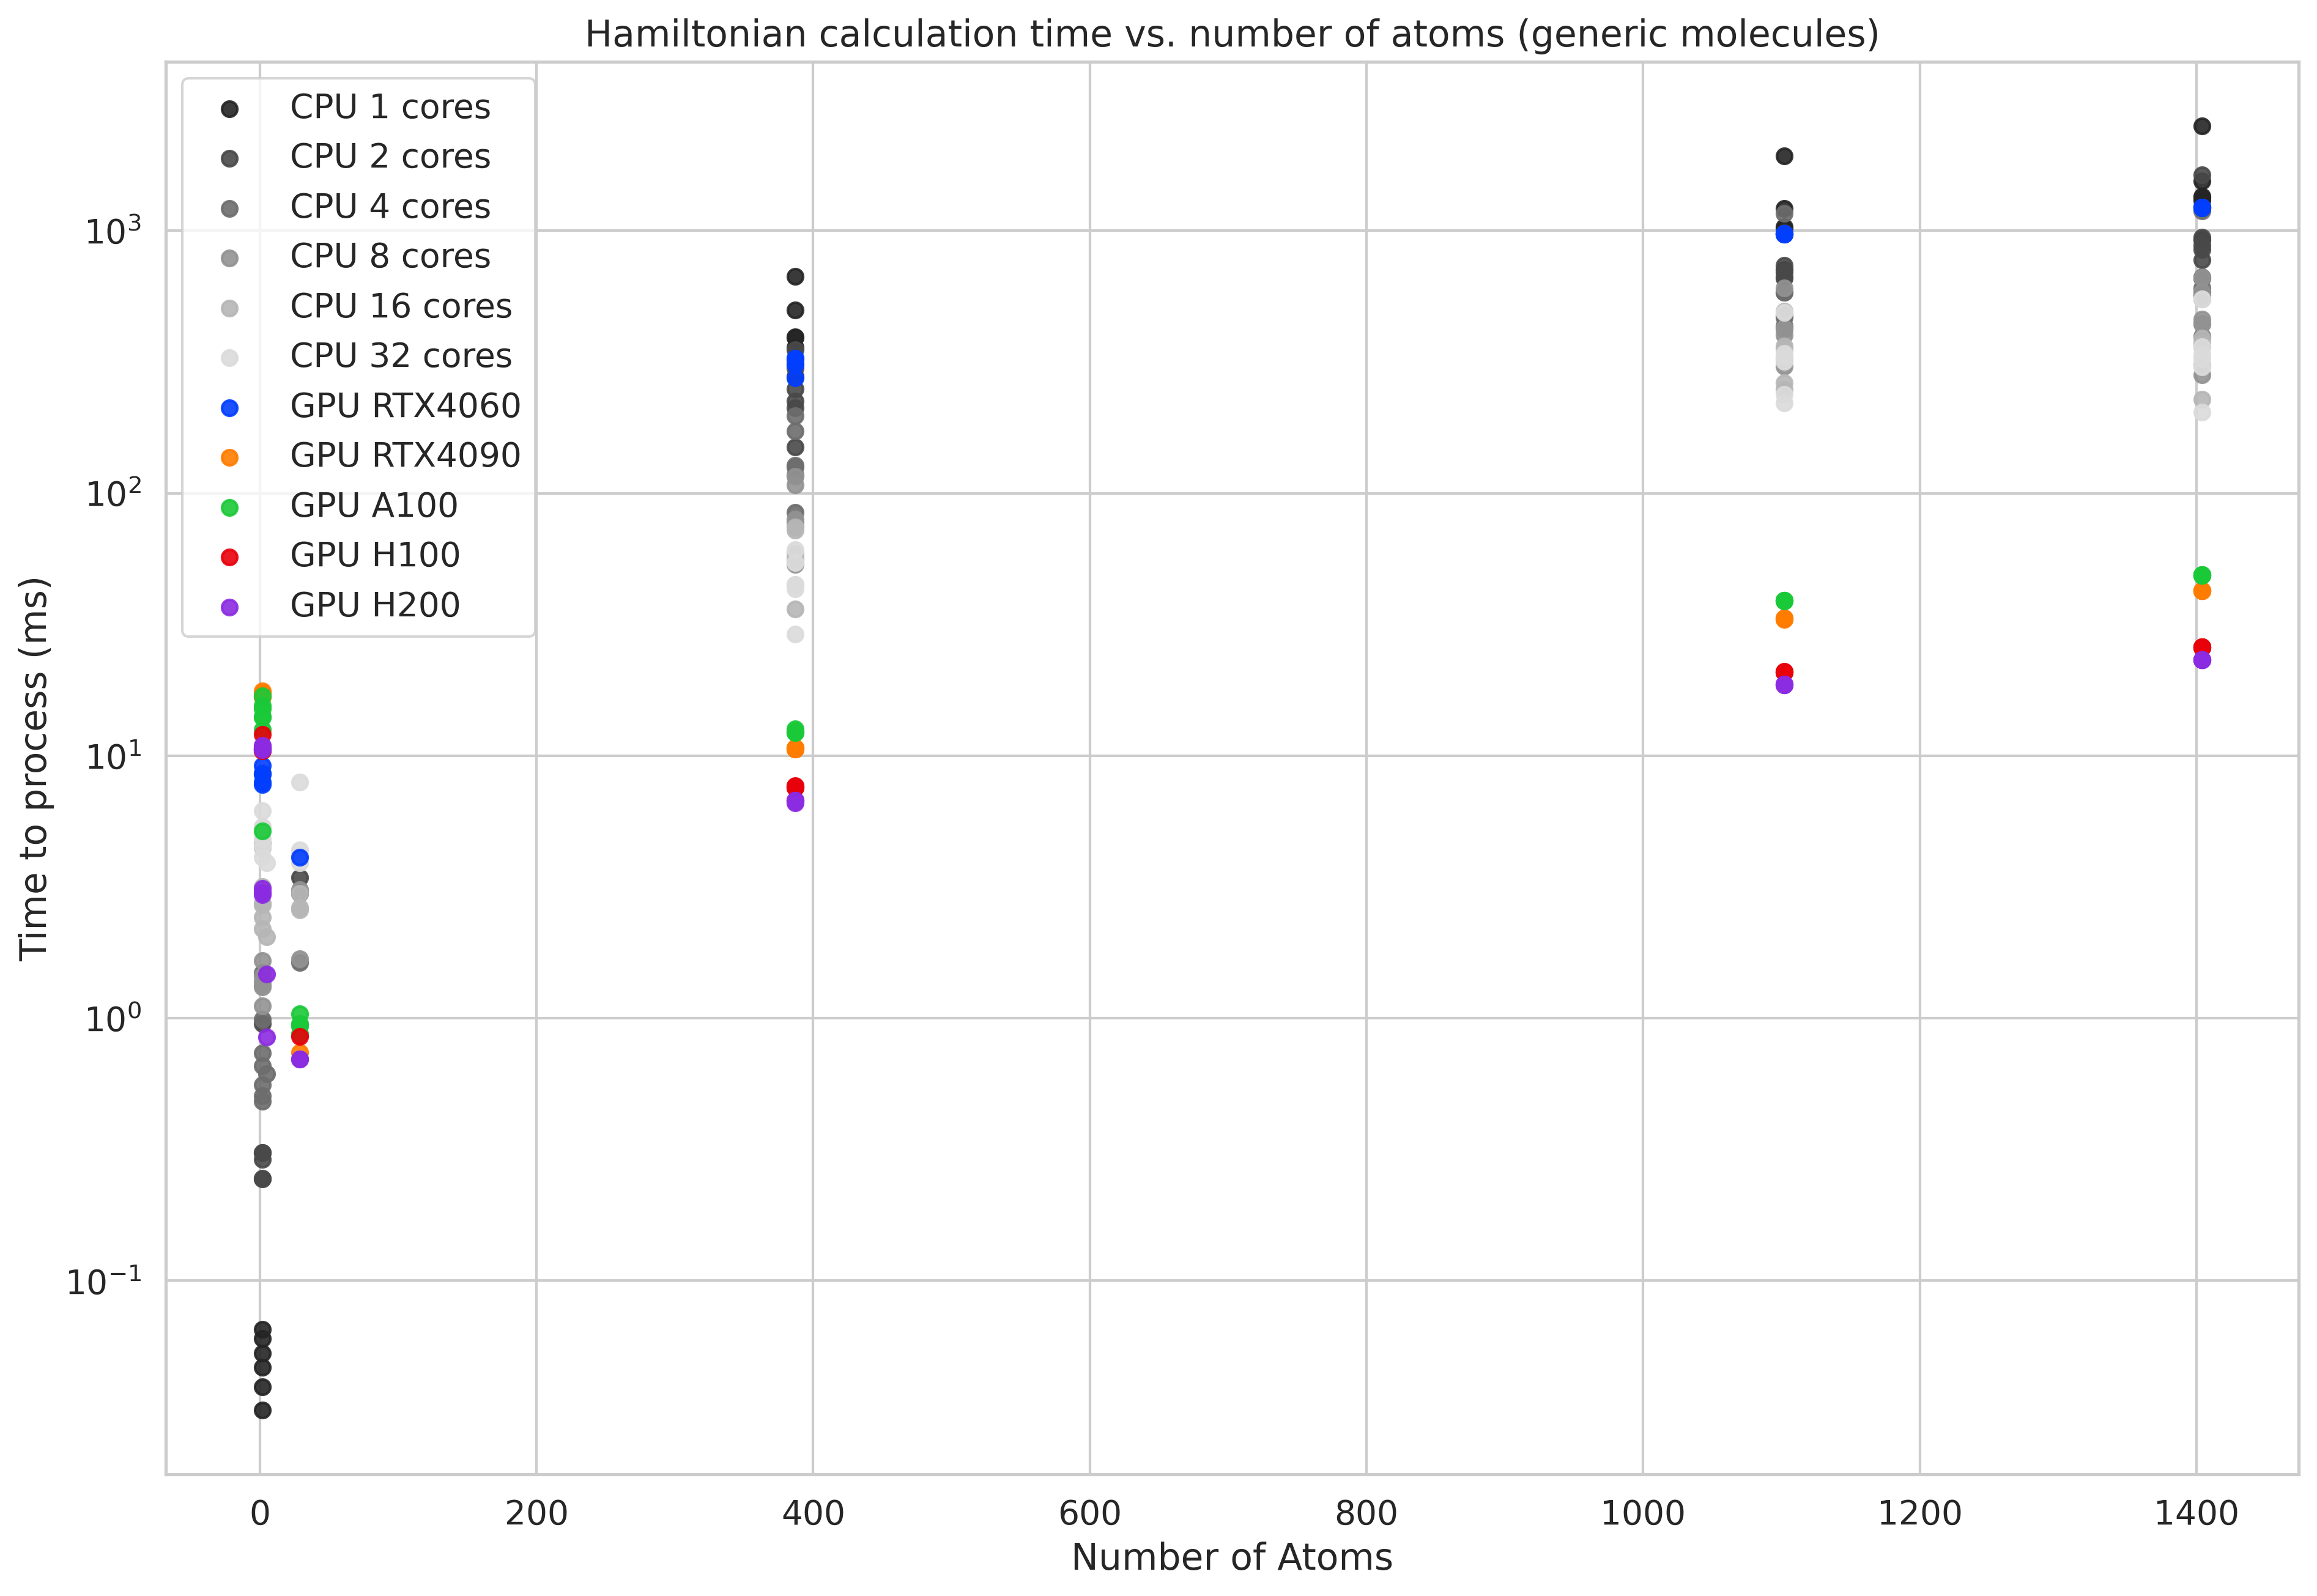

In [6]:
# First plot, plot 1/cpu_time and 1/gpu_time, over increasing number of atoms `nat` (x-axis).
# Lines: gray to black CPU, 1, 2, ... 32
# Lines: nvidia green, GPUs, rtx4060, rtx4090, h100
plt.figure(figsize=(15, 10), dpi=300)
sns.set_style("whitegrid")
sns.set_palette("dark")
sns.set_context("notebook", font_scale=1.2)

# Plot CPU data
df = df.sort_values(by='nat')
natoms = df['nat']
cpu_times = df['cpu_time']
cpu_cores = df['ncpu']
gpu_times = df['gpu_time']
gpu_types = df['gpu_type']

cpu_palette = sns.color_palette("gray", n_colors=6)  # 6 shades of gray for 1, 2, 4, 8, 16, 32 cores
for i, ncpu in enumerate([1, 2, 4, 8, 16, 32]):
  mask = (cpu_cores == ncpu)
  plt.scatter(natoms[mask], cpu_times[mask], 
           label=f'CPU {ncpu} cores', color=cpu_palette[i], alpha=0.9)

# gpu_palette = sns.color_palette("Greens", n_colors=6)  # 3 shades of green for rtx4060, rtx4090, h100
gpu_palette = sns.color_palette("bright", n_colors=12)  # Bright palette for GPUs
for i, gpu_type in enumerate(['rtx4060', 'rtx4090', 'a100', 'h100', 'h200']):
  mask = (gpu_types == gpu_type)
  color = gpu_palette[i]
  plt.scatter(natoms[mask], gpu_times[mask], label=f'GPU {gpu_type.upper()}', color=color, alpha=0.9)

plt.xlabel('Number of Atoms')
plt.ylabel('Time to process (ms)')
plt.yscale('log')
plt.title('Hamiltonian calculation time vs. number of atoms (generic molecules)')
plt.legend()

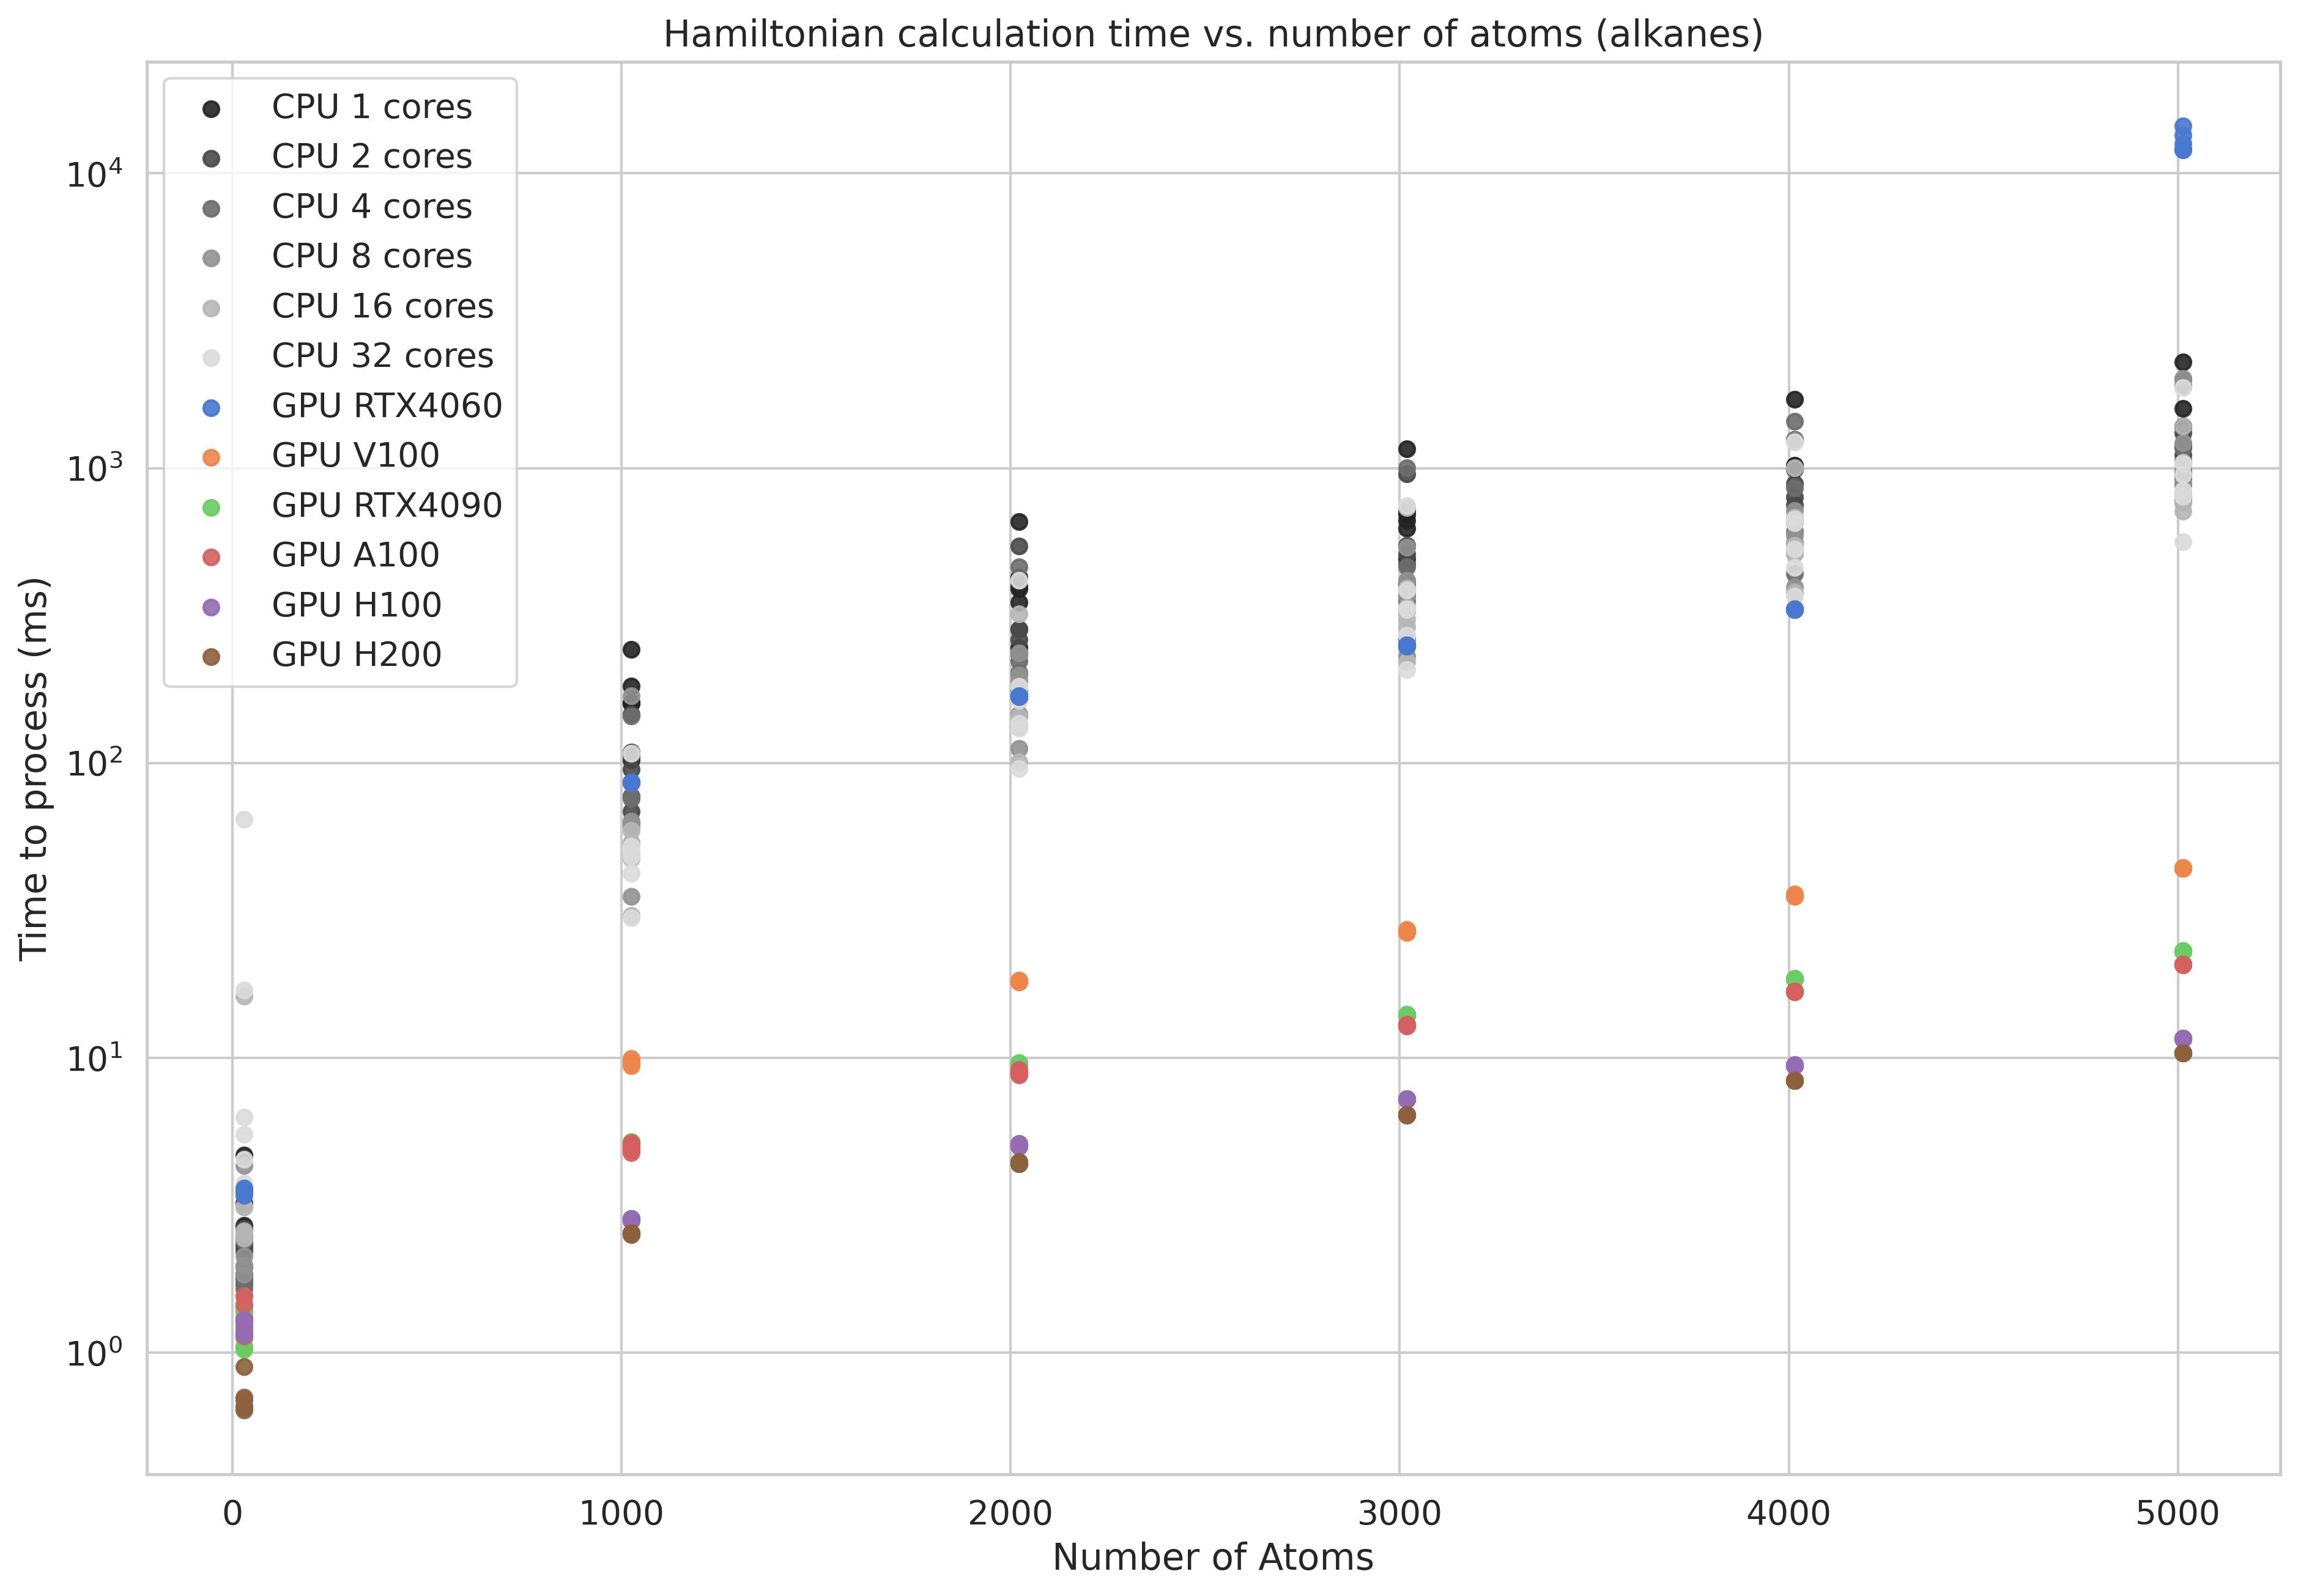

In [14]:
# First plot, plot 1/cpu_time and 1/gpu_time, over increasing number of atoms `nat` (x-axis).
# Lines: gray to black CPU, 1, 2, ... 32
# Lines: nvidia green, GPUs, rtx4060, rtx4090, h100
plt.figure(figsize=(15, 10), dpi=300)
sns.set_style("whitegrid")
sns.set_palette("dark")
sns.set_context("notebook", font_scale=1.2)

# Plot CPU data
df = alkanes.sort_values(by='nat')
natoms = df['nat']
cpu_times = df['cpu_time']
cpu_cores = df['ncpu']
gpu_times = df['gpu_time']
gpu_types = df['gpu_type']

cpu_palette = sns.color_palette("gray", n_colors=6)  # 6 shades of gray for 1, 2, 4, 8, 16, 32 cores
for i, ncpu in enumerate([1, 2, 4, 8, 16, 32]):
  mask = (cpu_cores == ncpu)
  plt.scatter(natoms[mask], cpu_times[mask], 
           label=f'CPU {ncpu} cores', color=cpu_palette[i], alpha=0.9)

# gpu_palette = sns.color_palette("Greens", n_colors=6)  # 3 shades of green for rtx4060, rtx4090, h100
gpu_palette = sns.color_palette("muted", n_colors=12)  # Viridis palette for GPUs
for i, gpu_type in enumerate(['rtx4060', 'v100', 'rtx4090', 'a100', 'h100', 'h200']):
  mask = (gpu_types == gpu_type)
  color = gpu_palette[i]
  plt.scatter(natoms[mask], gpu_times[mask], label=f'GPU {gpu_type.upper()}', color=color, alpha=0.9)

plt.xlabel('Number of Atoms')
plt.ylabel('Time to process (ms)')
plt.yscale('log')
plt.title('Hamiltonian calculation time vs. number of atoms (alkanes)')
plt.legend()